Brute n=3 cost=24 time=0.0000s
Brute n=4 cost=37 time=0.0000s
Brute n=5 cost=43 time=0.0000s
Brute n=6 cost=43 time=0.0001s
Brute n=7 cost=49 time=0.0006s
Held-Karp n=3 cost=24 time=0.0000s
Held-Karp n=4 cost=37 time=0.0000s
Held-Karp n=5 cost=43 time=0.0001s
Held-Karp n=6 cost=43 time=0.0002s
Held-Karp n=7 cost=49 time=0.0005s
Held-Karp n=8 cost=50 time=0.0014s
Held-Karp n=9 cost=32 time=0.0021s
Held-Karp n=10 cost=51 time=0.0047s


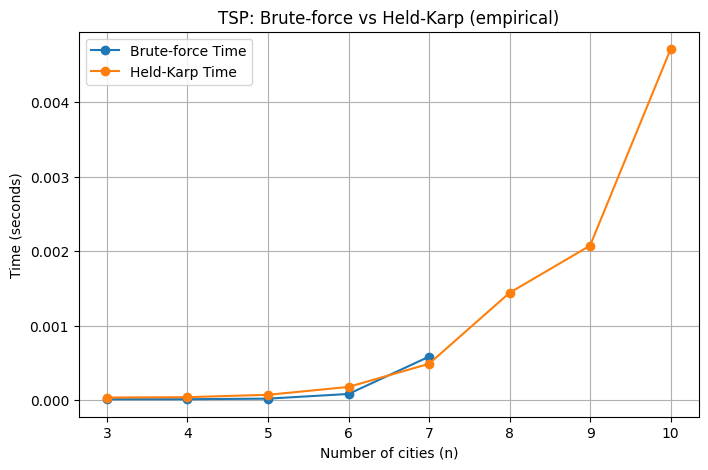

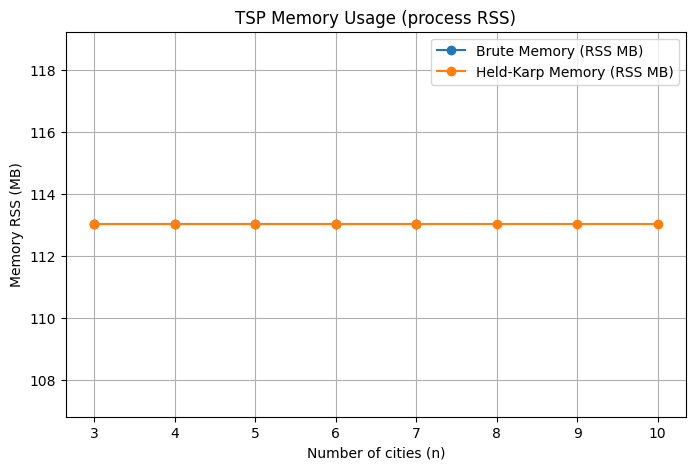

Sample n = 7 best cost: 49 route: (0, 3, 5, 2, 6, 1, 4, 0)


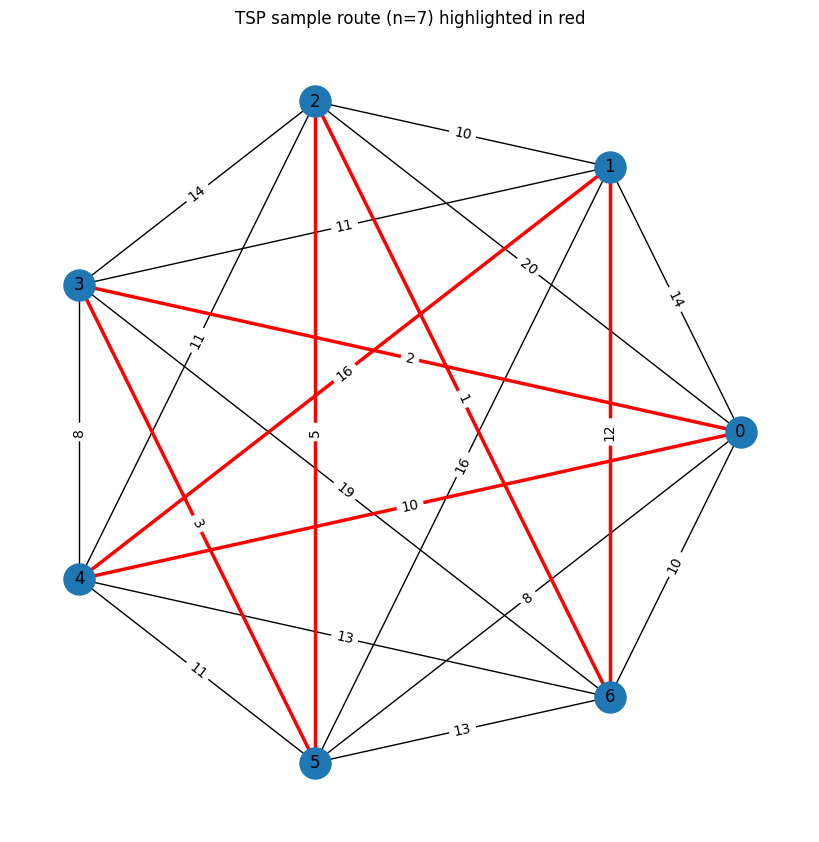


Uploaded assignment PDF (local path): /mnt/data/Capstone Assignment.pdf


In [2]:
# Algorithm 4: Corrected TSP (Brute-force + Held-Karp DP) with Time & Memory graphs
# Colab-ready. If networkx not installed in your environment, uncomment the pip install lines.

# !pip install networkx
# !pip install psutil

import itertools
import time
import psutil, os
import random
import matplotlib.pyplot as plt

try:
    import networkx as nx
except Exception as e:
    nx = None
    print("networkx not found — route plotting will be skipped. To enable plotting run: !pip install networkx")

# ---------------- Utility: make symmetric distance matrix ----------------
def generate_distance_matrix(n, seed=100, max_w=20):
    random.seed(seed + n)
    mat = [[0]*n for _ in range(n)]
    for i in range(n):
        for j in range(i+1, n):
            w = random.randint(1, max_w)
            mat[i][j] = w
            mat[j][i] = w
    return mat

# ---------------- Brute-force TSP (returns best cost and route) ----------
def tsp_bruteforce(dist_matrix):
    n = len(dist_matrix)
    nodes = list(range(n))
    best_cost = float('inf')
    best_route = None
    # exclude start 0 in permutations to reduce duplicates
    for perm in itertools.permutations(nodes[1:]):
        route = (0,) + perm + (0,)
        cost = 0
        for i in range(len(route)-1):
            cost += dist_matrix[route[i]][route[i+1]]
        if cost < best_cost:
            best_cost = cost
            best_route = route
    return best_cost, best_route

# ---------------- Held-Karp DP (O(n^2 * 2^n)) --------------------------
def tsp_held_karp(dist_matrix):
    n = len(dist_matrix)
    # DP[mask][i] = min cost to reach set mask and end at i (i included in mask)
    # We'll use dicts for sparse representation
    ALL = (1<<n)
    dp = [dict() for _ in range(ALL)]
    # base: starting at 0
    dp[1<<0][0] = 0

    for mask in range(ALL):
        if not (mask & 1):   # only masks that include start 0
            continue
        for u in range(n):
            if not (mask & (1<<u)):
                continue
            if u not in dp[mask]:
                continue
            cur_cost = dp[mask][u]
            # try to go to v not in mask
            for v in range(n):
                if mask & (1<<v):
                    continue
                new_mask = mask | (1<<v)
                new_cost = cur_cost + dist_matrix[u][v]
                old = dp[new_mask].get(v, float('inf'))
                if new_cost < old:
                    dp[new_mask][v] = new_cost

    # close tour: all visited, return to 0
    full_mask = (1<<n) - 1
    best = float('inf')
    last_node = None
    if full_mask >= len(dp):
        pass
    for u, cost in dp[full_mask].items():
        total = cost + dist_matrix[u][0]
        if total < best:
            best = total
            last_node = u

    # reconstruct route (optional) — do a simple reconstruction if needed
    # We'll reconstruct by walking backwards (not super-optimized but ok for small n)
    route = None
    if best < float('inf'):
        route = [0]
        mask = full_mask
        u = last_node
        route = [0]
        stack = [u]
        # backtrack
        cur_mask = mask
        cur_u = u
        while cur_mask != (1<<0):
            route.append(cur_u)
            # find previous node p such that dp[cur_mask ^ (1<<cur_u)][p] + dist[p][cur_u] == dp[cur_mask][cur_u]
            found = False
            prev_mask = cur_mask ^ (1<<cur_u)
            for p, pcost in dp[prev_mask].items():
                if pcost + dist_matrix[p][cur_u] == dp[cur_mask][cur_u]:
                    cur_u = p
                    cur_mask = prev_mask
                    found = True
                    break
            if not found:
                # fallback: break to avoid infinite loop
                break
        route.append(0)
        route = list(reversed(route))
    return best, tuple(route) if route else None

# ---------------- Profile runner for sizes ------------------------------
def profile_tsp(sizes_brute=[3,4,5,6,7,8,9], sizes_hk=[3,4,5,6,7,8,9,10], seed=123):
    brute_times = []
    hk_times = []
    brute_mems = []
    hk_mems = []

    for n in sizes_brute:
        mat = generate_distance_matrix(n, seed=seed)
        # brute force
        t0 = time.time()
        cost, route = tsp_bruteforce(mat)
        t1 = time.time()
        brute_times.append(t1 - t0)
        brute_mems.append(psutil.Process(os.getpid()).memory_info().rss / (1024*1024))
        print(f"Brute n={n} cost={cost} time={t1-t0:.4f}s")

    for n in sizes_hk:
        mat = generate_distance_matrix(n, seed=seed)
        t0 = time.time()
        cost, route = tsp_held_karp(mat)
        t1 = time.time()
        hk_times.append(t1 - t0)
        hk_mems.append(psutil.Process(os.getpid()).memory_info().rss / (1024*1024))
        print(f"Held-Karp n={n} cost={cost} time={t1-t0:.4f}s")

    return {
        'sizes_brute': sizes_brute,
        'brute_times': brute_times,
        'brute_mems': brute_mems,
        'sizes_hk': sizes_hk,
        'hk_times': hk_times,
        'hk_mems': hk_mems
    }

# ---------------- Plotting helper -------------------------------------
def plot_results(results):
    plt.figure(figsize=(8,5))
    # Brute
    plt.plot(results['sizes_brute'], results['brute_times'], marker='o', label='Brute-force Time')
    # Held-Karp
    plt.plot(results['sizes_hk'], results['hk_times'], marker='o', label='Held-Karp Time')
    plt.xlabel("Number of cities (n)")
    plt.ylabel("Time (seconds)")
    plt.title("TSP: Brute-force vs Held-Karp (empirical)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Memory plot
    plt.figure(figsize=(8,5))
    # for sizes mismatch lengths, plot separately
    plt.plot(results['sizes_brute'], results['brute_mems'], marker='o', label='Brute Memory (RSS MB)')
    plt.plot(results['sizes_hk'], results['hk_mems'], marker='o', label='Held-Karp Memory (RSS MB)')
    plt.xlabel("Number of cities (n)")
    plt.ylabel("Memory RSS (MB)")
    plt.title("TSP Memory Usage (process RSS)")
    plt.legend()
    plt.grid(True)
    plt.show()

# ---------------- Example: run profiling (adjust sizes if needed) ------
# WARNING: Brute grows very fast. If Colab runtime slow, reduce sizes_brute/sizes_hk.
sizes_brute = [3,4,5,6,7]          # safe brute sizes (you can extend to 8/9 if you want)
sizes_hk    = [3,4,5,6,7,8,9,10]   # held-karp up to 10 (increase with caution)

results = profile_tsp(sizes_brute=sizes_brute, sizes_hk=sizes_hk, seed=777)
plot_results(results)

# ---------------- Plot one sample route using networkx (for n=7 if networkx available) ---------------
def plot_sample_route(n=7, seed=777):
    mat = generate_distance_matrix(n, seed=seed)
    # compute held-karp (safer for moderate n)
    cost, route = tsp_held_karp(mat)
    if route is None:
        print("Route not reconstructed; skipping plot.")
        return
    print("Sample n =", n, "best cost:", cost, "route:", route)

    if nx is None:
        print("networkx not installed; install it to see route plot: !pip install networkx")
        return

    G = nx.Graph()
    for i in range(n):
        G.add_node(i)
    # positions in circle for visualization
    pos = {i: (10 * __import__('math').cos(2*__import__('math').pi*i/n),
               10 * __import__('math').sin(2*__import__('math').pi*i/n)) for i in range(n)}
    # add edges with weights for visibility
    for i in range(n):
        for j in range(i+1,n):
            G.add_edge(i, j, weight=mat[i][j])
    plt.figure(figsize=(8,8))
    nx.draw(G, pos, with_labels=True, node_size=500)
    # highlight route edges
    rt_edges = [(route[i], route[i+1]) for i in range(len(route)-1)]
    nx.draw_networkx_edges(G, pos, edgelist=rt_edges, edge_color='r', width=2.5)
    edge_labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)
    plt.title(f"TSP sample route (n={n}) highlighted in red")
    plt.show()

# plot a sample route (choose n small enough, e.g., 7 or 8)
plot_sample_route(n=7, seed=777)

# ---------------- Resource: uploaded assignment file path ----------------
print("\nUploaded assignment PDF (local path): /mnt/data/Capstone Assignment.pdf")
